In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

In [35]:
def read_data(data):
    """Read the data from the file."""
    return np.loadtxt(data)

In [36]:
number = 6 # Value of the system size. Needs to be changed manually.

In [37]:
# name = f"L{number}_J1.00_q8"
# folder = f"results/{name}/"

# file = f"{folder}{name}.txt"

# q=int(name[-1])

name = "test_ising"
folder = "results/test_ising/"
file = f"{folder}{name}.txt"
q = 2

In [38]:
lng = read_data(file)

In [39]:
lng = lng[lng[:, 1] > 1]

def normalize_lng(lng_):
    norm = np.log(8) + lng_ - lng_[0]
    return norm

lng[:, 1] = normalize_lng(lng[:, 1])

In [40]:
# save this data as a file txt with two columns
savename = f"{folder}{name}_no0.txt"
np.savetxt(savename, lng, fmt='%.6f %.6f')

In [41]:
beta_c = np.log(1 + np.sqrt(q))/2
print(beta_c)

0.44068679350977147


In [42]:
lng_df = pd.DataFrame(columns=["E", "lng"])
lng_df["E"] = lng[:, 0]
lng_df["lng"] = lng[:, 1]

/var/folders/0f/g4_t3r9d0nd2ht__gmq9q52m0000gn/T/ipykernel_4752/2267007890.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


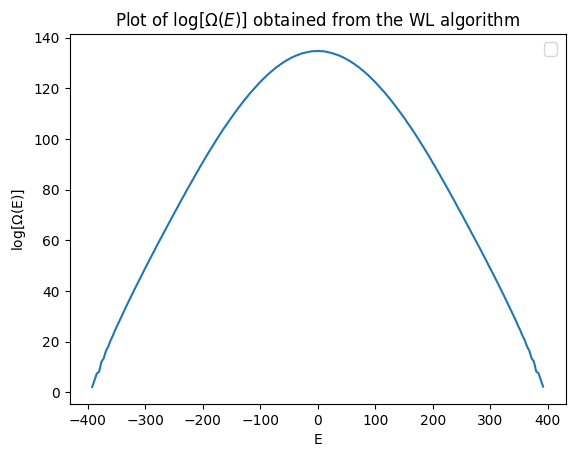

In [43]:
plt.plot(lng[:, 0], lng[:, 1])#, label=r"L = %.0f" % int(name[1]))
plt.xlabel('E')
plt.ylabel(r'log[$\Omega$(E)]')
plt.title(r"Plot of $\log[\Omega(E)]$ obtained from the WL algorithm")
plt.legend(fontsize=12)
plt.show()

In [44]:
from ipywidgets import interact, FloatSlider

log_omega = lng[:, 1]
E = lng[:, 0]

def update_plot(beta):
   
    W = log_omega - beta * E
    W_max = np.max(W)

    log_Z = W_max + np.log(np.sum(np.exp(W - W_max)))

    A_ = log_Z - W
    
    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot(-E, A_, label=f'beta={beta}')
    plt.xlabel('E')
    plt.ylabel('A(E)')
    plt.title('A(E)')

    plt.legend()
    plt.grid()
    plt.show()

# Interactive slider
interact(update_plot, beta=FloatSlider(value=beta_c, min=0, max=4, step=0.0001))


interactive(children=(FloatSlider(value=0.44068679350977147, description='beta', max=4.0, step=0.0001), Output…

<function __main__.update_plot(beta)>

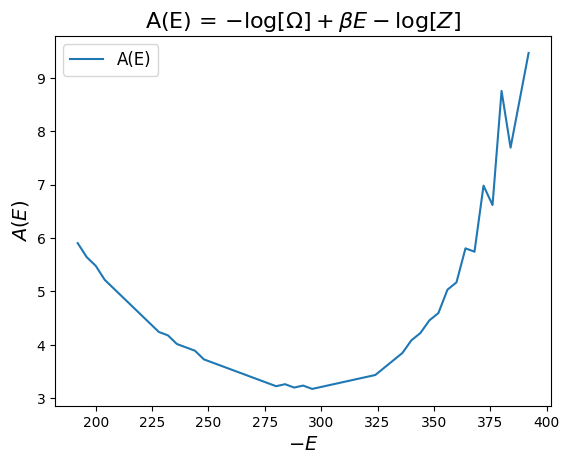

In [45]:
# Obtain A
log_omega = lng[:, 1]
E = lng[:, 0]
beta = beta_c
W = log_omega - beta * E
W_max = np.max(W)

log_Z = W_max + np.log(np.sum(np.exp(W - W_max)))

A_ = log_Z - W 

plt.plot(-E[(E < -190) & (E > -490)], A_[(E < -190) & (E > -490)], label='A(E)')
plt.xlabel(r'$-E$', fontsize=14)
plt.ylabel(r'$A(E)$', fontsize=14)
plt.title(r'A(E) = $- \log[\Omega] + \beta E - \log[Z]$', fontsize=16)
plt.legend(fontsize=12)
plt.show()


In [13]:
def A(E, beta):
    W = log_omega - beta * E
    W_max = np.max(W)
    log_Z = W_max + np.log(np.sum(np.exp(W - W_max)))
    return log_Z - W

In [14]:
def search_minima(beta, min, max):
    """
    Search for the minima of A(E) for a given beta.
    
    Parameters:
    -----------
    beta: np.array
        Values of beta to search the minima.
    """
    E_A = [] # must be a list of arrays with the values of E and A for each minima for each beta
    diff = []
    E_max = []
    A_max = []
    for b in beta:
        A_int = A(E, b)
        A_int = interp1d(-E, A_int, kind='cubic')

        E_interp = np.linspace(min, max, 1000)

        # sort the values of A and E according to A sorted
        A_sorted = np.sort(A_int(E_interp))
        E_sorted = E_interp[np.argsort(A_int(E_interp))]

        E_sor = []
        A_sor = []
        E_sor.append(E_sorted[0])
        A_sor.append(A_sorted[0])

        

        for i in range(1, E_sorted.size):
            if np.abs(E_sorted[i] - E_sorted[0]) > 40:
                E_sor.append(E_sorted[i])
                A_sor.append(A_sorted[i])
                break
        E_A.append(np.column_stack((E_sor, A_sor)))
        diff.append(np.abs(A_sor[0]-A_sor[1]))
        
        # E between E_sor[0] and E_sor[1]
        A_aux = 0
        if E_sor[0] > E_sor[1]:
            A_aux = np.max(A_int(E_interp)[(E_interp >= E_sor[1]) & (E_interp <= E_sor[0])])
            
        else:
            A_aux = np.max(A_int(E_interp)[(E_interp >= E_sor[0]) & (E_interp <= E_sor[1])])
        E_max.append(E_interp[np.where(A_int(E_interp) == A_aux)])
        A_max.append(A_aux)

    # print the value of E that corresponds to A_aux
        
    E_A = np.array(E_A)
    diff = np.array(diff)
    E_max = np.array(E_max)
    A_max = np.array(A_max)
    
    # sort diff from lowest to highest
    EA = E_A[np.argsort(diff)]
    E_max = E_max[np.argsort(diff)]
    A_max = A_max[np.argsort(diff)]

    # dataframe with columns beta_sorted, E_A, diff
    df = pd.DataFrame({'beta_sorted': beta[np.argsort(diff)], 'E_min_0': EA[:, 0, 0], 'E_min_1': EA[:, 1, 0], 'A_0': EA[:, 0, 1], 'A_1': EA[:, 1, 1], 'diff': np.sort(diff), 'E_max': E_max[:, 0], 'A_max': A_max})
    
    return df


In [15]:
ranges = {"L9": [50, 147], "L10": [65, 185], "L11": [90, 230], "L12": [95, 280], "L14": [160, 360], "L16": [190, 490]}

In [16]:
beta = np.linspace(beta_c-0.1, beta_c+0.1, 1000)
beta_df = search_minima(beta, ranges[f"L{number}"][0], ranges[f"L{number}"][1])

KeyError: 'L6'

In [ ]:
plt.plot(-E, A(E, beta_df["beta_sorted"][0])), label=r'L = , $\beta$ = {:.4f}'.format(beta_df["beta_sorted"][0]))
plt.scatter(beta_df["E_min_0"][0], beta_df["A_0"][0], color='red')
plt.scatter(beta_df["E_min_1"][0], beta_df["A_1"][0], color='red')
plt.scatter(beta_df["E_max"][0], beta_df["A_max"][0], color='green')
# add text with the value of the difference 
deltaF = beta_df["A_max"][0] - ((beta_df["A_0"][0] + beta_df["A_1"][0])/2)
plt.text(330, 5.3, r"$\Delta F = {:.4f}$".format(deltaF), fontsize=10)

plt.arrow(beta_df["E_max"][0], beta_df["A_0"][0]+0.15, 0, beta_df["A_max"][0]-beta_df["A_0"][0]-0.3, head_width=5, head_length=0.1, fc='black', ec='black')
plt.arrow(beta_df["E_max"][0], beta_df["A_max"][0]-0.15, 0, -beta_df["A_max"][0]+beta_df["A_0"][0]+0.3, head_width=5, head_length=0.1, fc='black', ec='black')

plt.axhline(y=beta_df["A_max"][0], color='green', xmin=0.3, xmax=0.6, linestyle='--')
plt.axhline(y=(beta_df["A_0"][0] + beta_df["A_1"][0])/2,  xmin=0.1, xmax=0.9, color='red', linestyle='--')

plt.xlabel(r'$-E$', fontsize=14)
plt.ylabel(r'$A(E)$', fontsize=14)
plt.xlim(ranges[f"L{number}"][0], ranges[f"L{number}"][1])
plt.ylim(4, 7)
plt.title(rf'$A(E)$ for $L={number}$, $q=8$, $\beta$ = {beta_df["beta_sorted"][0]:.5}', fontsize=14)
plt.savefig(f"../images/A{number}.png")
plt.show()


In [ ]:
deltaF = beta_df["A_max"][0] - ((beta_df["A_0"][0] + beta_df["A_1"][0])/2)
print(((beta_df["A_0"][0] + beta_df["A_1"][0])/2))
print(deltaF)

In [ ]:
L_deltaF = np.loadtxt("L_deltaF.txt")

plt.scatter(L_deltaF[:, 0], L_deltaF[:, 1], label=r'$\Delta$F')
plt.xlabel(r'$L$', fontsize=14)
plt.ylabel(r'$\Delta$F', fontsize=14)
plt.title(r'$\Delta$F vs L', fontsize=14)
plt.legend()
plt.show()

In [ ]:
# fit the data with a line
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a*x + b

popt, pcov = curve_fit(linear, L_deltaF[:, 0], L_deltaF[:, 1])

plt.scatter(L_deltaF[:, 0], L_deltaF[:, 1], label=r'$\Delta$F')
plt.plot(L_deltaF[:, 0], linear(L_deltaF[:, 0], *popt), label='Linear fit', color='tab:orange', linestyle='--')
plt.xlabel(r'$L$', fontsize=14)
plt.ylabel(r'$\Delta$F', fontsize=14)
plt.title(r'$\Delta$F vs L', fontsize=14)
plt.legend()
plt.show()

In [ ]:
# print constants and their error
print(popt)
print(np.sqrt(np.diag(pcov)))

